# Search-based Synthesis Guide

This tutorial will introduce a user to the search-based synthesis tools available as part of BQSKit. By the end of this tutorial, a user will gain experience with the QSearch and LEAP synthesis passes and how to customize them.

## Search-based Synthesis

Quantum circuit synthesis is the process of converting a mathematical description of a quantum transformation, often given as a unitary matrix, into a circuit composed of gates from a fixed gate set. The search-based class of synthesis tools is categorized by the discrete search for a desired circuit through a space of circuits. These techniques are usually bottom-up, they start with an empty circuit and grow out as they search through the space.

#### QSearch

QSearch is a powerful search-based synthesis tool, which phrases the problem of circuit synthesis as a search over circuit structures combined with numerical optimization to instantiate circuit parameters. The algorithm starts by placing single-qubit rotations on all qubits. The circuit is then instantiated by calling a numerical optimization subroutine to solve for the gate's parameters that minimize the distance between the circuit's unitary and the target unitary. After this, fixed building blocks composed of two-qubit gates followed by single-qubit rotations are placed on all pairs of qubits. This branching pattern forms the circuit tree, seen below, where at depth n in the tree, all possible circuit structures with n two-qudit gates exist. Each structure is a candidate solution is evaluated using the same numerical optimization process, and the order of evaluations is determined by A* search.


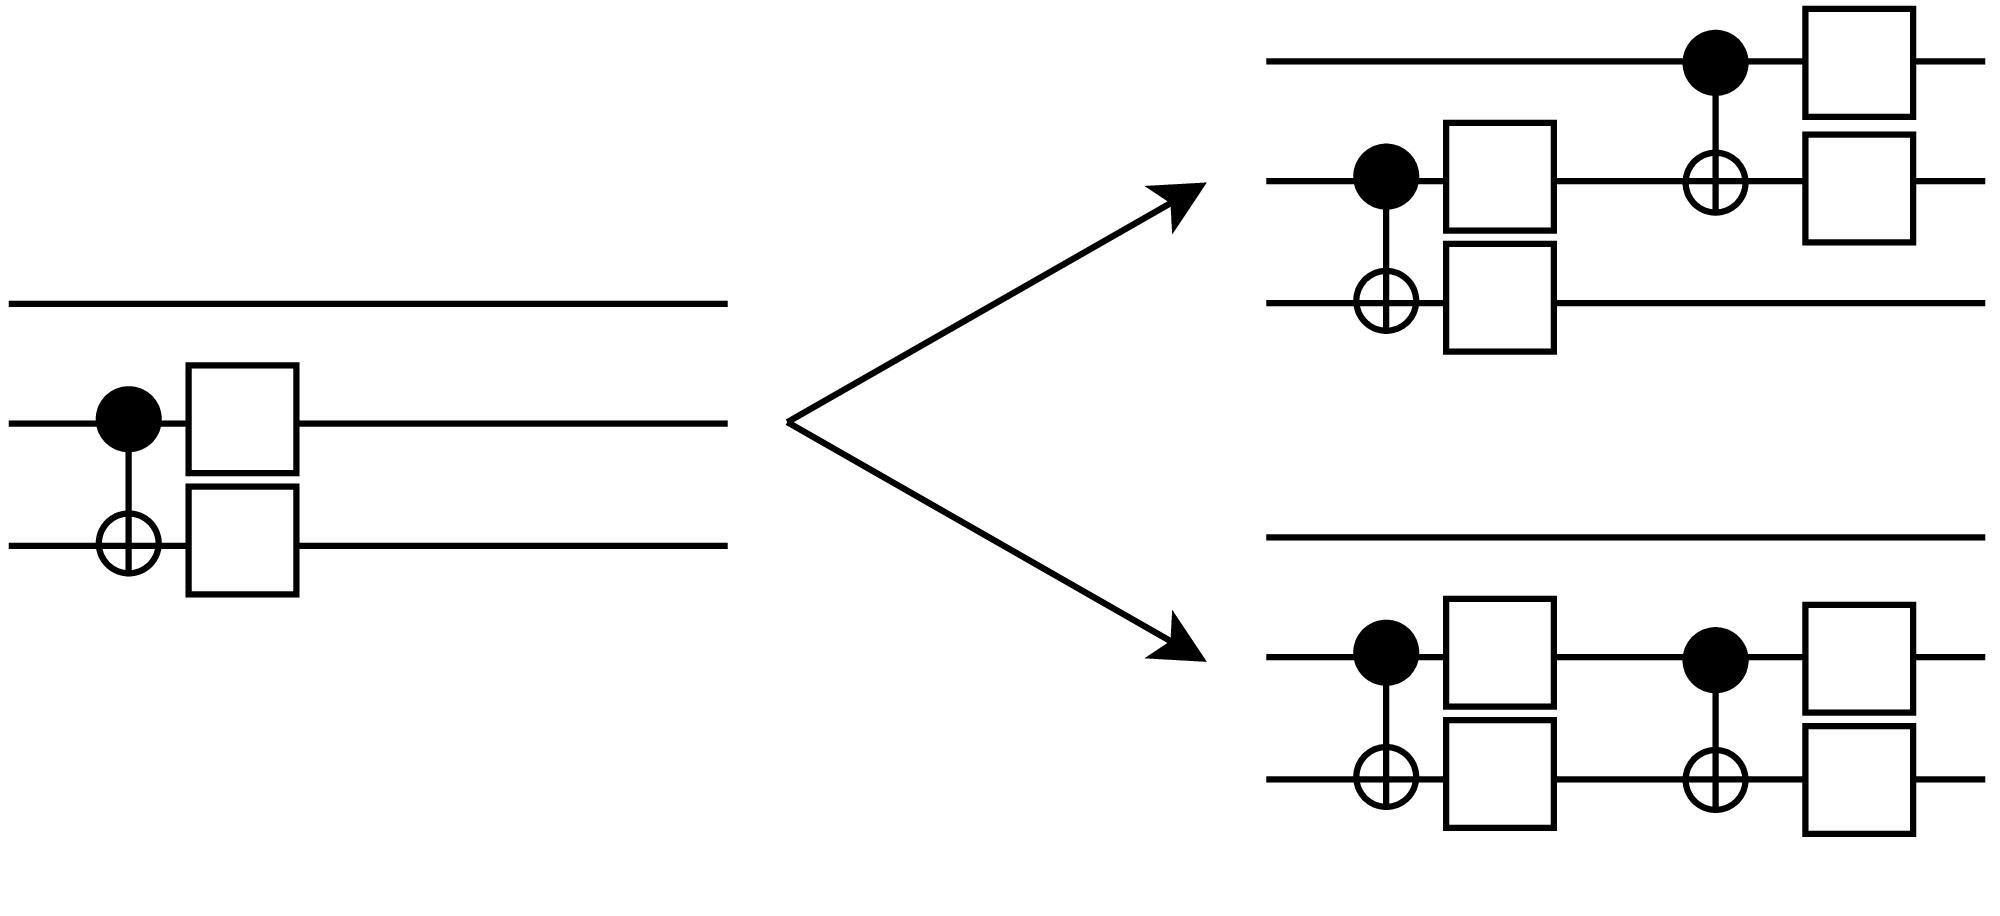

#### LEAP

QSearch produces circuits of very high quality: usually optimal in depth and with errors at the floating-point level. In theory the algorithm can work on a circuit of any size, however in practice, this is not the case. Due to the exponential rate of growth in the circuit tree and necessary backtracking, QSearch does not scale well past 4-qubit circuits. LEAP is an extension of the algorithm that modifies the search encouraging deeper movement into the search space with less backtracking. This does improve the scalability while maintaining very high quality results.

### Properties

- **Portable:** While the original algorithms extensively studied circuits with the CNOT and U3 gateset, in theory all universal gate sets can be supported.

- **Topology-Aware:** Synthesis tools that produce circuits requiring no mapping to a hardware topology are said to be topology-aware. Since QSearch's and LEAP's search space branches on two-qudit placement, by limiting the possible placements of two-qudit gates is enough to produce topology aware tools.

### BQSKit Implementations

BQSKit implements both the QSearch and LEAP algorithms and are well integrated into the BQSKit framework. This allows the algorithms to fully take advantage of their properties.

1) Let's start with a simple example using QSearch off-the-shelf to synthesize a toffoli circuit:

In [1]:
from bqskit import Circuit
from bqskit import Compiler
from bqskit import UnitaryMatrix
from bqskit import CompilationTask
from bqskit.passes import QSearchSynthesisPass

# Encode the toffoli unitary
toffoli_unitary = UnitaryMatrix([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0],
])

# Inputs to the BQSKit compiler must be a circuit
# So first we place the toffoli unitary into a circuit
# Note: NumPy arrays are interchangable with UnitaryMatrix objects
circuit = Circuit.from_unitary(toffoli_unitary)

# We must now tell the compiler that we would like to execute QSearch
# This is done by creating a CompilationTask with the circuit as the input
# and only a QSearchSynthesisPass object in the workflow.
task = CompilationTask(circuit, [QSearchSynthesisPass()])

# Finally, we construct a compiler and submit the task
with Compiler() as compiler:
    synthesized_circuit = compiler.compile(task)
    
print(synthesized_circuit)

Circuit(3)[U3Gate@(0,) ... U3Gate@(1,)]


In [2]:
# We can print some information about the circuit

# Display the length of the critical path in the circuit
print("Critial Path Length:", synthesized_circuit.depth)

# Display the parallelism in the circuit
print("Parallelism:", synthesized_circuit.parallelism)

# Display the total number of gates
print("Total Number of Operations:", synthesized_circuit.num_operations)

# As well as specific numbers
from bqskit.ir.gates import CNOTGate, U3Gate
print("CNOT Count:", synthesized_circuit.count(CNOTGate()))
print("U3 Count:", synthesized_circuit.count(U3Gate()))

# We can even see the logical connectivity of the circuit
print("Interacting Qubit Pairs:", synthesized_circuit.coupling_graph)

Critial Path Length: 13
Parallelism: 2.076923076923077
Total Number of Operations: 21
CNOT Count: 6
U3 Count: 15
Interacting Qubit Pairs: {(0, 1), (0, 2), (1, 2)}


## Accuracy

BQSKit's algorithms are all approximate, meaning that the results might be slightly different than the inputs. This is controllable and most of the time is at the floating-point level. However, we should always check our results when possible:

In [3]:
out_utry = synthesized_circuit.get_unitary()
out_utry.get_distance_from(toffoli_unitary)

0.0

This function uses a metric based on the Hilbert-Schmidt inner product:

$$| U_T - U_C | = \sqrt{1 - \frac{|Tr(U_T^\dagger U_C)|}{2^n}^2}$$

This distance is global phase agnostic meaning that $U_T$ and $U_C$ are considered equal if they differ by only a global phase.

**Change Target Accuracy**
If the degree of approximation is too large you can adjust the `success_threshold` parameter in QSearch. This parameter is used to determine convergence of the algorithm. If the unitary implemented by the circuit differs from the target unitary by less than this number, then the algorithm claims success. You may also want to adjust the parameter to allow for more error in the hopes of finding a shorter circuit. This will all depend on your environment and goals.


**Exercise:** Try changing the success threshold in the following example. What do you expect will happen?

In [4]:
# We can increase the success threshold allowing for greater error in the result
# Note 1e-1 is a very high error
configured_qsearch_pass = QSearchSynthesisPass(success_threshold=1e-1)

# Create and execute a compilation task
with Compiler() as compiler:
    task = CompilationTask(circuit, [configured_qsearch_pass])
    synthesized_circuit = compiler.compile(task)

print("New Circuit CNOT Count:", synthesized_circuit.count(CNOTGate()))
out_utry = synthesized_circuit.get_unitary()
print("New Circuit Error:", out_utry.get_distance_from(toffoli_unitary))

New Circuit CNOT Count: 4
New Circuit Error: 0.3826835183412315


Also observe that the printed error is probably higher than the success threshold. This is because, by default, QSearch internally uses a very simple distance calculation for faster calculations.

## Gatesets and Layer Generation

By default, the QSearch algorithm uses `U3Gate`s and `CNOTGate`s:

In [5]:
synthesized_circuit.gate_set

{CNOTGate, U3Gate}

This can be changed by configuring the way QSearch generates layers in the search tree. These options are entirely modular and fully customizable. QSearch uses a LayerGenerator object to generate the candidate circuits that make up its search space. By default, a layer generator that places CNOT and U3 gate blocks is used. We can easily swap out the single- and two- qubit gates used in the same layer generation algorithm, or we can write our own algorithm entirely. This can be done by subclassing `LayerGenerator` and implementing the API.

**Exercise:** Modify the below code to produce a toffoli circuit using the gates of your choice. You can find the gates currently implemented in BQSKit here (TODO) and you can learn how to implement your own here (TODO). Which gate set produces the best result?

In [6]:
from bqskit.passes.search import SimpleLayerGenerator
from bqskit.ir.gates import ISwapGate, PauliGate

# We can use the same layer generation algorithm
# and just change the gates used
layer_gen = SimpleLayerGenerator(two_qudit_gate=ISwapGate(), single_qudit_gate_1=U3Gate())

configured_qsearch_pass = QSearchSynthesisPass(layer_generator=layer_gen)

# Create and execute a compilation task
with Compiler() as compiler:
    task = CompilationTask(circuit, [configured_qsearch_pass])
    synthesized_circuit = compiler.compile(task)

for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

ISwapGate Count: 7
U3Gate Count: 17


**Advanced**

We can customize the generation of layers even further. The `SimpleLayerGenerator` places building blocks composed of two-qudit gates followed by single-qudit gates, which has a history in practice. However, this entire flow is modular. The `LayerGenerator` API requires us to implement two methods `gen_initial_layer` and `gen_successors`. In the below example, we do something a bit more unnatural.

For more information, see the API Documentation here (TODO).

**Exercise** Alter the below example to generate layers however you would like. Consider customizing the gate set, how successors are generated, and how you would implement topology-awareness here.

In [20]:
from bqskit.ir.gates import RXXGate, RYYGate, RZZGate, U3Gate
from bqskit.passes.search import LayerGenerator

class CustomLayerGenerator(LayerGenerator):
    
    def gen_initial_layer(self, target, data):
        """
        Here we will generate the first circuit that seeds the search space.
        
        By default, the SimpleLayerGenerator places single-qudit gates
        on each qudit. Here let's do something a little more crazy
        to demonstrate the potential.
        """
        
        init_circuit = Circuit(target.num_qudits, target.radixes)
        
        # Place RXX Gates on consective pairs of qudits
        for i in range(init_circuit.num_qudits - 1):
            init_circuit.append_gate(RXXGate(), (i, i+1))
        
        return init_circuit
    
    def gen_successors(self, circuit, data):
        """
        During the search, this will be called when expanding a node.
        
        By default, the SimpleLayerGenerator produces new circuits with
        one more block of gates on each valid edge. Again, let's be
        a little crazy here too.
        """
        
        base_successor = circuit.copy()
        
        # Apply a column of U3Gates
        for i in range(base_successor.num_qudits):
            base_successor.append_gate(U3Gate(), i)
        
        successors = []
        
        # Create 3 successors
        # Each one has a line of a specific type of gate.
        for gate in [RXXGate(), RYYGate(), RZZGate()]:
            successor = base_successor.copy()
            for i in range(base_successor.num_qudits - 1):
                successor.append_gate(gate, (i, i+1))
            successors.append(successor)

        return successors

    
# We can now use this layer generator just like the simple one
configured_qsearch_pass = QSearchSynthesisPass(layer_generator=CustomLayerGenerator())

# Create and execute a compilation task
with Compiler() as compiler:
    task = CompilationTask(circuit, [configured_qsearch_pass])
    synthesized_circuit = compiler.compile(task)
    
for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

RXXGate Count: 42
U3Gate Count: 52


Note that what we do here might not produce the shortest circuits since we are adding more gates at each step, but one advantage is that the circuit grows quicker and will most likely converge quicker.

This layer generation technique is will most likely be useful to synthesize larger unitaries quicker.

## Search Heuristics

The QSearch algorithm was original designed for use with the A* search heuristic, but this is also configurable in BQSKit's implementation. The search heuristic determines the order in which candidate solutations are evaluated and expanded. There are three that are implemented for you: `AStarHeuristic`, `DijkstraHeuristic`, `GreedyHeuristic`. These also have an API that you can implement if you would like to customize it further.

**Exercise:** Modify the below code to use the different heuristics. How do the results change?

In [8]:
from bqskit.passes.search import AStarHeuristic, DijkstraHeuristic, GreedyHeuristic

configured_qsearch_pass = QSearchSynthesisPass(heuristic_function=GreedyHeuristic())

# Create and execute a compilation task
with Compiler() as compiler:
    task = CompilationTask(circuit, [configured_qsearch_pass])
    synthesized_circuit = compiler.compile(task)
    
for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

U3Gate Count: 39
CNOTGate Count: 18


## Topology-Aware Synthesis

Everything that we have done so far has been purely virtual. There has been no concept of a physical quantum processor and the restrictions that come with using a real one. We can program the BQSKit workflow with information about a physical machine; QSearch and LEAP will take advantage of this information and produce circuits that are already mapped to a machine's topology.

Note that this is programmed in the layer generator. If you would like to continue using a custom one from a previous exercise, you can implement topology awareness in there. Take a look at the source code for the `SimpleLayerGenerator` to see how it is done there.


In [9]:
from bqskit.compiler import MachineModel
from bqskit.passes import SimpleLayoutPass

# A MachineModel object models a physical machine
# Here model is a three-qubit model with a linear topology
model = MachineModel(3, [(0, 1), (1, 2)])

# We use a layout pass to:
#    1) associate a MachineModel with the compiler flow
#    2) assign logical to physical qudits
task = CompilationTask(circuit, [
    SimpleLayoutPass(model),
    QSearchSynthesisPass(),
])

with Compiler() as compiler:
    synthesized_circuit = compiler.compile(task)
    
print("Circuit Coupling Graph:", synthesized_circuit.coupling_graph)
for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

Circuit Coupling Graph: {(0, 1), (1, 2)}
U3Gate Count: 19
CNOTGate Count: 8


## The LEAP Algorithm

The LEAP algorithm implemented in BQSKit supports the exact same features as QSearch. The search algorithm is just slightly different to encourage deeper searches rather than wider ones.

**Exercise:** Run the below example, how does the synthesized toffoli circuit differ when compiled with LEAP vs QSearch. Modify the example, making use of all the options you learned for QSearch.

In [11]:
from bqskit.passes import LEAPSynthesisPass

task = CompilationTask(circuit, [LEAPSynthesisPass()])

with Compiler() as compiler:
    synthesized_circuit = compiler.compile(task)
    
for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

U3Gate Count: 15
CNOTGate Count: 6


## Putting It Together

**Exercise:** Three unitaries of different sizes are hardcoded below. Try experiment with different configurations of search based synthesis. Some general tips:

- LEAP will generally be faster with a slight hit to circuit depth
- Use of more expressive gates will usually converge quicker but produce longer circuits
- Search strategies that explore deeper into the circuit space quicker will often times converge quicker
- Using off-the-shelf QSearch on a 5-qubit unitary likely will not converge
- If you want the best results, it will take experimentation

In [15]:
# Three qubit fredkin or Controlled-Swap gate
fredkin_unitary = UnitaryMatrix([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
])

# X-Gate with three controls (CCCX)
cccx_unitary = UnitaryMatrix([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
])

# An XXXXX(np.pi/4) rotation
import math
xxxxx_unitary = PauliGate(5).get_unitary([math.pi/4 if i == 341 else 0 for i in range(4**5)])

In [22]:
# Change this to other unitaries
circuit = Circuit.from_unitary(fredkin_unitary)

task = CompilationTask(circuit, [
    # Build your own compiler workflow here
])

with Compiler() as compiler:
    synthesized_circuit = compiler.compile(task)
    
for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

ConstantUnitaryGate Count: 1
